In [1]:
from collections import defaultdict
import gzip, pickle

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm.auto as tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# uint8 is not popular
y_train = y_train.astype('i4')
y_test = y_test.astype('i4')

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype('f4')
x_test = x_test[..., tf.newaxis].astype('f4')
n_train = x_train.shape[0]

In [4]:
class CVAECategorical(tfk.Model):
    def __init__(self, ncat, ngaus):
        super(CVAECategorical, self).__init__()

        self.ncat = ncat
        self.ngaus = ngaus
        self.latent_cat_prior = tfd.OneHotCategorical(probs=tf.ones(ncat) / ncat, dtype=tf.float32)
        self.latent_gaus_prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ngaus), scale_diag=tf.ones(ngaus))

        self.encoder = tfk.Sequential([
            tfk.layers.Input((28, 28, 1)),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Flatten(),
            tfk.layers.Dense(ncat + 2*ngaus),
        ])

        self.decoder = tfk.Sequential([
            tfk.layers.Input(ncat + ngaus),
            tfk.layers.Dense(12*12*6, activation='relu'),
            tfk.layers.Reshape((12, 12, 6)),
            tfk.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=32, kernel_size=4, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=1, kernel_size=1),
        ])
    
    def encode(self, inputs):
        '''Encode
        '''
        params = self.encoder(inputs)
        catp, mean, var = tf.split(params, [self.ncat, self.ngaus, self.ngaus], axis=-1)
        # ensure valid domain
        catp, var = tf.nn.softmax(catp), tf.math.softplus(var)
        cat_dist = tfd.OneHotCategorical(probs=catp, dtype=tf.float32)
        gaus_dist = tfd.MultivariateNormalDiag(loc=mean, scale_diag=var)
        return cat_dist, gaus_dist
    
    def decode(self, cat_vec, gaus_vec, logit=False):
        '''Decode
        '''
        latent = tf.concat([cat_vec, gaus_vec], axis=-1)
        out = self.decoder(latent)
        if not logit:
            out = tf.sigmoid(out)
        return out
    
    def call(self, inputs, logit=False):
        latent = self.encode(inputs)
        out = self.decode(latent, logit=logit)
        return out

In [5]:
model = CVAECategorical(10, 8)
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                2

In [6]:
def analytic_kl(u1, s1, u2, s2):
    '''For two normal distributions'''
    return np.log(s2/s1) + (s1**2 + (u1 - u2)**2)/(2*(s2**2)) - .5

analytic_kl(.1, 1.1, 0, 1)

0.014689820195675218

In [7]:
@tf.function
def sampling_kl(dist_a, dist_b):
    samples = dist_a.sample(10)
    logp_a = tf.reduce_mean(dist_a.log_prob(samples), axis=0)
    logp_b = tf.reduce_mean(dist_b.log_prob(samples), axis=0)
    return logp_a - logp_b

In [8]:
@tf.function
def calculate_loss(images, labels):
    unlabeled = labels < 0
    cat_labels = tf.one_hot(labels, depth=model.ncat)

    latent_cat, latent_gaus = model.encode(images)
    kl_cat = tfd.kl_divergence(latent_cat, model.latent_cat_prior)
    kl_gaus = tfd.kl_divergence(latent_gaus, model.latent_gaus_prior)
    # kl = tf.reduce_mean(sampling_kl(latent, model.latent_prior))
    # http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
    magic = - 0.1 * model.ncat * latent_cat.log_prob(cat_labels)
    kl = tf.where(unlabeled, kl_cat + kl_gaus, magic + kl_gaus)

    latent_cat_sample = tf.where(tf.expand_dims(unlabeled, -1), latent_cat.sample(), cat_labels)
    latent_gaus_sample = latent_gaus.sample()
    output = model.decode(latent_cat_sample, latent_gaus_sample, logit=True)
    dist = tf.nn.sigmoid_cross_entropy_with_logits(labels=images, logits=output)
    nll = tf.reduce_sum(dist, axis=[1, 2, 3])

    return tf.reduce_mean(nll + kl)

In [9]:
optimizer = tfk.optimizers.Adam()
train_loss = tfk.metrics.Mean(name='train_loss')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        loss = calculate_loss(images, labels)

    trainable = model.trainable_variables
    gradients = tape.gradient(loss, trainable)
    optimizer.apply_gradients(zip(gradients, trainable))

    train_loss(loss)

In [10]:
test_loss = tfk.metrics.Mean(name='test_loss')

@tf.function
def test_step(images, labels):
    loss = calculate_loss(images, labels)
    test_loss(loss)

In [11]:
EPOCHS = 100
BATCH_SIZE = 100

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

history = defaultdict(list)


for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    optimizer.lr = 1e-3
    for images, labels in train_ds:
        labels_dropout = tf.where(tf.random.uniform(labels.shape) > 0.2, -1, labels)
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, labels)

    history['train_loss'].append(float(train_loss.result()))
    history['test_loss'].append(float(test_loss.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_loss.reset_states()


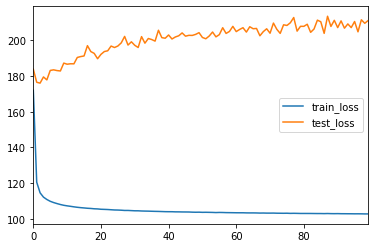

In [12]:
pd.DataFrame(history)[:].plot()

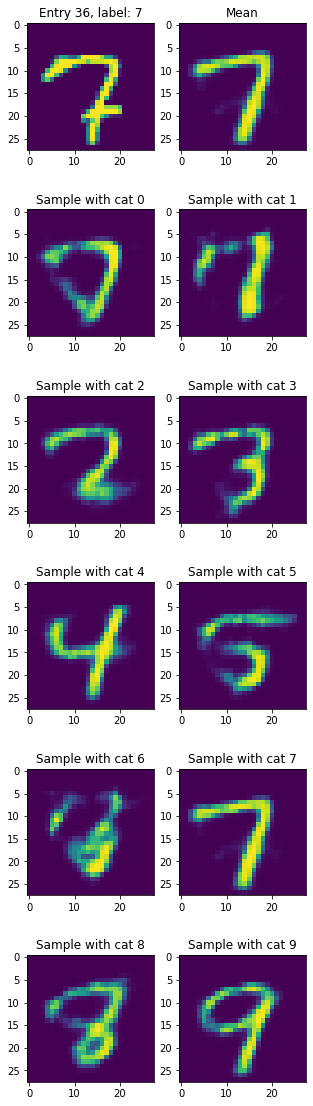

In [16]:
i = 36

ex = x_test[i,...,0]
lbl = y_test[i]

fig, axes = plt.subplots(ncols=2, nrows=1 + model.ncat//2, figsize=(5, 20))

axes[0][0].set_title("Entry %d, label: %d" % (i, lbl))
axes[0][0].imshow(ex)

latent_cat, latent_gaus = model.encode(ex[None, ..., None])

axes[0][1].set_title("Mean")
axes[0][1].imshow(model.decode(latent_cat.mean(), latent_gaus.mean())[0, ..., 0])

for newcat, ax in enumerate(axes.flatten()[2:]):
    ax.set_title('Sample with cat %d' % newcat)
    onehot = tf.expand_dims(tf.one_hot(newcat, depth=model.ncat), 0)
    ax.imshow(model.decode(onehot, latent_gaus.sample())[0, ..., 0])

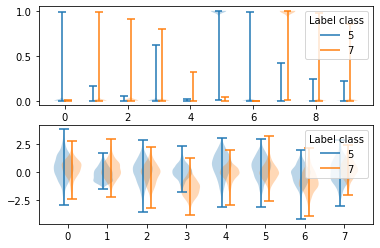

In [14]:
lbl1, lbl2 = 5, 7

fig, (cax, gax) = plt.subplots(2)

def vio(cut, offset):
    latent_cat, latent_gaus = model.encode(x_test[cut])
    mcat = latent_cat.mean().numpy()
    mgaus = latent_gaus.mean().numpy()
    cvio = cax.violinplot(mcat, positions=np.arange(model.ncat) + offset)
    gvio = gax.violinplot(mgaus, positions=np.arange(model.ngaus) + offset)
    return cvio, gvio

cvio_a, gvio_a = vio(y_test == lbl1, -.1)
cvio_b, gvio_b = vio(y_test == lbl2, +.1)

cax.legend([cvio_a['cbars'], cvio_b['cbars']], [str(lbl1), str(lbl2)], title='Label class')
gax.legend([gvio_a['cbars'], gvio_b['cbars']], [str(lbl1), str(lbl2)], title='Label class')